# How peeking at results can ruin your AB test

You've probably heard this before, no peeking at your results until the experiment is finished!  

But how bad can it be really?  Let's take a look.

Imagine that you are designing an experiment that will require 100,000 observations.  Given the traffic flow rate to your webpage, it will take 10 days to get that many users. So your experiment will have to run for the full 10 days before you can make an informed decision.  Now, let's consider two scenarios.  In the first scenario you wait until all the data has been collected before conducting your analysis and concluding the experiment.  In the second scenario you peek at the data at the end of each day, analyze the data, and if the result is statistically significant you stop the test. Otherwise, if the result is not statistically significant, you allow the test to continue for up to a maximum of 10 days.  

To demonstrate how peeking will ruin your AB test we will simulate many AB tests under each of these two scenarios.  Importantly, the simulation will be with NO TRUE EFFECT -- there is no true difference between A and B throughout this example.  What that means is that, using a 95% confidence interval, we would expect only 5% of the simulated experiments to find a statistically significant effect.  Conversely, 95% should produce insignificant results.  

First, links to notebooks:

[R](https://github.com/darrelrobinson/a2bofdatascience/blob/main/analysis/peeking%20R.ipynb)

[Python](https://github.com/darrelrobinson/a2bofdatascience/blob/main/analysis/peeking%20python.ipynb)

In [1]:
options(tidyverse.quiet=TRUE)
suppressWarnings(library(tidyverse))
library(tidyverse)

Let's start with a function that pulls two samples of users and tests the difference between the two groups.  The sample will be collected over 10 days, and a significance test will be performed at the end of each day with the cumulative data.  If ```peeking=FALSE``` the data collection will run to the end, and only the p-value at the end of the test will be considered.  If however ```peeking=TRUE```, the data will stop being collected as soon as a statistically significant result is found.

In [2]:
p_value = function(obs, peeking=FALSE){
    a = rnorm(obs)
    b = rnorm(obs)
    p_vals = rep(NA, 10)
    for (i in 1:10){
        p_vals[i] = t.test(a[1:obs/10*i], b[1:obs/10*i])$p.value
        if(peeking==TRUE & p_vals[i] < 0.05){
            return(p_vals)
        }
    }
    return(p_vals)
}

Now we can apply that function to generate 100 simulated experiments for each scenario.  

In [3]:
set.seed(1453)
scenario_1 = replicate(100, p_value(10000, peeking=FALSE))
scenario_2 = replicate(100, p_value(10000, peeking=TRUE))

s1_df = scenario_1 %>%
  as.data.frame() %>%
  gather() %>%
  group_by(key) %>%
  mutate(day = row_number()) %>%
  mutate(significant = max(ifelse(value < 0.05 & day==10, 1, 0)))
  

s2_df = scenario_2 %>% 
  as.data.frame() %>% 
  gather() %>%
  group_by(key) %>%
  mutate(day = row_number()) %>%
  mutate(significant = max(ifelse(value < 0.05, 1, 0), na.rm=TRUE))

Now we can see what proportion of these simulated experiments returned a statistically significant result in the two different scenarios.  Remember, there is no true difference in either case, so the proportion of significant results should be close to 0.05, as per the 95% confidence interval.  Let's write a simple function to calculate the proportion of significant test results among our iterattions:

In [4]:
proportion_significant = function(df){
    df %>%
    group_by(key) %>%
    summarise(significant = max(significant), .groups='drop') %>%
    summarise(proportion_significant = mean(significant), .groups='drop')
}

### Scenario 1 - let the test run to conclusion

In the first scenario we find that 4% of our 100 simulated experiments returned a statistically significant result.  That means, if we let the test run to conclusion and wait with our analysis until all data has been collected, the confidence interval, and thus our conclusions, are in line with theoretical expectation.

In [5]:
proportion_significant(s1_df)

proportion_significant
<dbl>
0.04


### Scenario 2 - check the data at the end of each day and stop the test if statistically significant

In the second scenario however a total of 77% of the simulated experiments returned a statistically significant result!  This is ridiculously high.  As you collect the data over the 10 days, most experiments will return a statistically significant result at some point.  But the only result that matters is the one at the end of the data collection period.  In this simple example, we could have tested 100 different features, and rolled out 77 of them, when in reality not a single one of them was an true statistically significant difference.  Keep in mind that the p-values we've calculated are for any difference, both positive and negative, but even still.  Since the data is just random noise, half of the significant estimates should be positive and half should be negative.  Which means that, if we were to roll out in the case of a positive significant result only, we still roll out nearly 40% of the time, when in fact not a single instance represents a true product improvement.  

In [6]:
proportion_significant(s2_df)

proportion_significant
<dbl>
0.77


Let's plot this data to see what happened.  We'll create a line plot with one line for each simulated experiment.  The x-axis represents the days of the data collection, from 1 to 10.  At the end of each day we calculated a p-value with the cumulative data up to that point.  The p-values are shown on the y-axis.  All of the grey lines represent experiments for which the result was statistically insignificant at the end of the 10 days, and the red lines represent the experiments for which the result was statistically significant at the end of the 10th day.  

As we see here, the p-values for any given experiment fluctuate greatly over the period of time, sometimes even dropping below the significance threshold.  But in ~95% of cases, the result at the end of the 10th day is a true insignificant conclusion.  

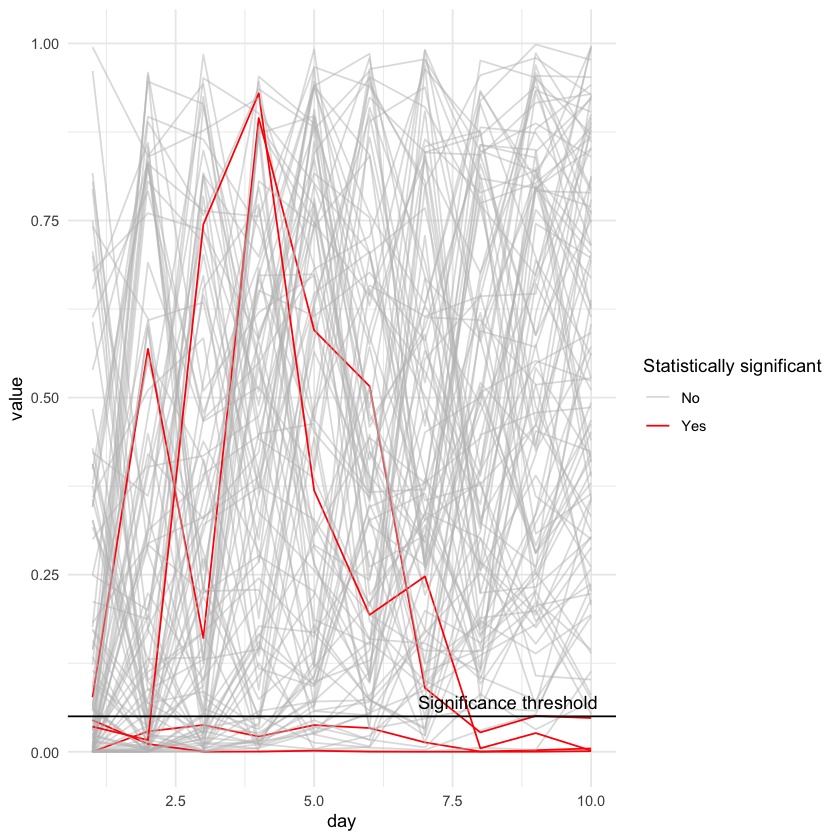

In [7]:
s1_df %>%
  mutate(`Statistically significant`= ifelse(significant==1, 'Yes', 'No')) %>%
  ggplot(aes(x=day, y=value, group=key, color=`Statistically significant`, alpha=`Statistically significant`)) + 
  geom_line() + 
  scale_color_manual(values=c('grey', 'red')) + 
  scale_alpha_manual(values=c(0.5, 1)) +
  geom_hline(yintercept=0.05) +
  annotate('text', y=0.07, x=8.5, label='Significance threshold') +
  theme_minimal()

When we create the same graph for the second scenario we see a lot more red.  Because so many experiments produce a statistically signficant result at some point during the 10-day window, the vast majority of experiments do not run to conclusion.  They are represented by the red lines that stop as soon as they drop below the 0.05 threshold.  But remember, these are all false significant results.  

Warning message:
“Removed 659 row(s) containing missing values (geom_path).”

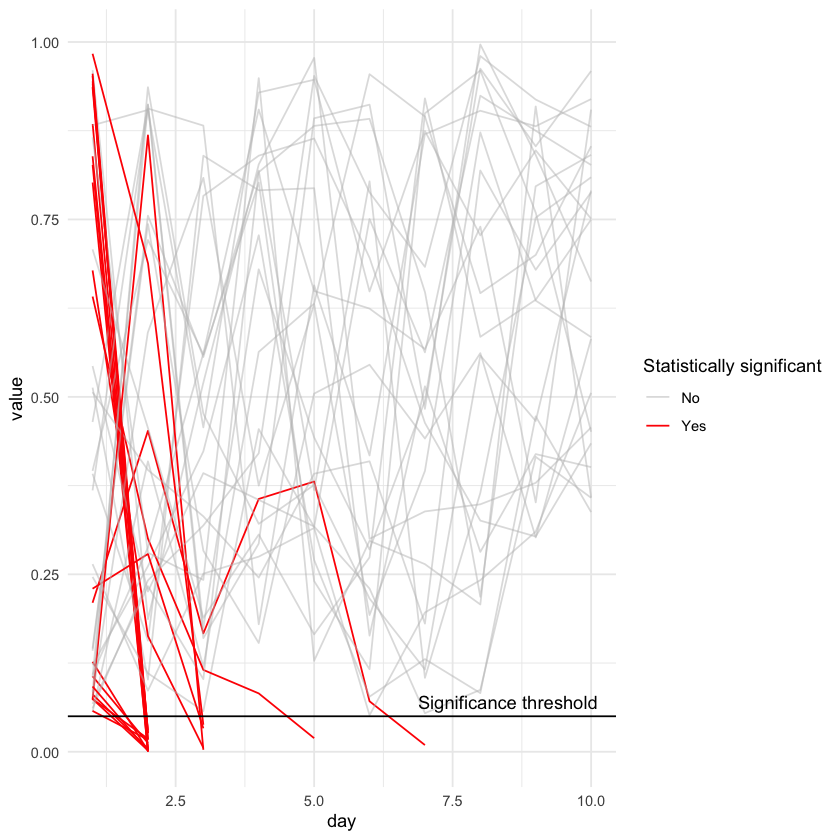

In [8]:
s2_df %>%
  mutate(`Statistically significant`= ifelse(significant==1, 'Yes', 'No')) %>%
  ggplot(aes(x=day, y=value, group=key, color=`Statistically significant`, alpha=`Statistically significant`)) + 
  geom_line() + 
  scale_color_manual(values=c('grey', 'red')) + 
  scale_alpha_manual(values=c(0.5, 1)) +
  geom_hline(yintercept=0.05) +
  annotate('text', y=0.07, x=8.5, label='Significance threshold') +
  theme_minimal()

# Peeking at results can ruin your experiment

There really is no good reason to peek at your results in order to test the primary outcome metric.  Even if you do that with no intention to stop the experiment, it is easy to rationalize to yourself that the results you are seeing are true.  Imagine a scenario where you peek at the results at the end of each day.  The result is statistically significant and positive, exactly as you predict, on days 1 through 9, but then on day 10 the result turns statistically insignificant.  You shouldn't roll out the new feature, but wouldn't it be tempting to roll it out anyway because of the results you saw on days 1 to 9?

There is one exception to the peeking rule, it is often good practice to examine the data at the beginning of the experiment to make sure that something is not broken.  You wouldn't want to be delivering a broken/terrible experience even to a small sample of users.  So by all means have a look to ensure that the groups seem split according to design, and that no metric appears to have completely tanked.  But after you have established that your experiment seems to be working as designed, do yourself a favour and find something else to do, and simply forget about the experiment until all of the data has been collected.  

